In [4]:
from operator import add
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.stats import LombScargle
from gatspy.periodic import LombScargleFast
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import numpy as np
from sqlite3 import *
import random

In [5]:
#conn = connect('minion_1016_sqlite.db')
conn = connect('astro_lsst_01_1004_sqlite.db')

In [6]:
# LSST zero points  u,g,r,i,z,y
zeroPoints = [0,26.5,28.3,28.13,27.79,27.4,26.58]
FWHMeff = [0.8,0.92,0.87,0.83,0.80,0.78,0.76] # arcmins?
pixelScale = 0.2
readOut = 12.7
sigSys = 0.005

In [7]:
def magUncertainy(Filter, objectmag, exposuretime,background, FWHM): # b is background counts per pixel   
    countsPS = 10**((Filter-objectmag)/2.5)
    counts = countsPS * exposuretime
    uncertainty = 1/(counts/((counts/2.3)+(((background/2.3)+(12.7**2))*2.266*((FWHM/0.2)**2)))**0.5) # gain assumed to be 1
    return uncertainty

In [8]:
magUncertainy(zeroPoints[0],20,30,100,FWHMeff[0])   

287210299.76535374

In [9]:
def findObservations(fields): #fields are array in the format [(630,), (631,)] etc
    global obs, allobs, uobs, gobs, robs, iobs, zobs, yobs
    x2 = fields # field containing gx 339-4
    L = [0]*len(x2)
    z = 0
    c = conn.cursor()
    #t = [('357',),('356',)]
    for z in range(0,len(x2)):
        i = x2[z]    
        #c.execute('SELECT expMJD, Field_fieldID, filter FROM ObsHistory WHERE Field_fieldID = ?',i)
        #k = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE Field_fieldID = ?', i)
        allobs = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "u" AND Field_fieldID = ?', i)
        uobs= c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "g" AND Field_fieldID = ?', i)
        gobs = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "r" AND Field_fieldID = ?', i)
        robs = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "i" AND Field_fieldID = ?', i)
        iobs = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "z" AND Field_fieldID = ?', i)
        zobs = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "y" AND Field_fieldID = ?', i)
        yobs = c.fetchall()
        
    obs = [allobs, uobs, gobs, robs, iobs, zobs, yobs]
    for x in range(0, len(obs)):
        for y in range(0, len(obs[x])):
            obs[x][y] = np.mean(obs[x][y])
        

In [10]:
def addsecondExposure():
    #global obs, allobs2, uobs2, gobs2, robs2, iobs2, zobs2, yobs2
    #obs = [allobs, uobs, gobs, robs, iobs, zobs, yobs]
    for x in range(0, len(obs)):
        for y in range(0, len(obs[x])):
            obs[x][y] = np.mean(obs[x][y])
    allobs2, uobs2, gobs2, robs2, iobs2, zobs2, yobs2 = [], [], [], [], [], [], []
    
    obs2 = [allobs2, uobs2, gobs2, robs2, iobs2, zobs2, yobs2]
    for x in range(0, len(obs)):
        obs2[x] = [t + (17./(3600*24)) for t in obs[x]]
    for x in range(0, len(obs)):
        obs[x].extend(obs2[x])
    for x in range(0, len(obs)):
        obs[x] = sorted(obs[x])
    # creates observation 17 seconds after first

In [11]:
def averageFlux(observations, Frequency, exptime):
    b = [0]*len(observations)
    for seconds in range(0, exptime):
        a = [np.sin((2*np.pi*(Frequency*0.01))*(x-observations[0]+(seconds*(3600*24)))) for x in observations] # optical modulation
        b = map(add, a, b)
    c = [z/exptime for z in b]
    return c

In [12]:
def flaring(B, length, frequency=0, amplitude=1):   
    global flareMag
    np.linspace(0,np.log(8),length)
    fouriers = np.linspace(1,3000,length)
    logF = [np.log(x) for x in fouriers]
    real = [random.gauss(0,1)*((1/x)**(B/2)) for x in fouriers]
    #imaginary = [random.gauss(0,1)*((1/x)**(B/2)) for x in fouriers]
    IFT = np.fft.ifft(real)
    seconds = np.linspace(0,length, length)
    minutes = [x for x in seconds]
    plt.show()
    minimum = (np.max(-IFT))
    positive = [x + minimum for x in IFT]
    normalised = [x/(np.mean(positive)) for x in positive]
    flareMag = [amplitude * x for x in normalised]
    return flareMag

In [ ]:
def confidenceLevel(numsteps): # no sigma clipping?
    position = min(range(len(periods)), key=lambda i: abs(periods[i]-LSperiod))
    if position > numsteps:
        sigma = np.std(power[(position-numsteps):(position+numsteps)])
        mean = np.mean(power[(position-numsteps):(position+numsteps)])
    else:
        sigma = np.std(power[0:(position+numsteps)])
        mean = np.mean(power[0:(position+numsteps)])
    confidence = mean + (5*sigma)
    return confidence

In [157]:
def lombScargle(frequencyRange, objectmag, modulationAmplitude=0.1, background=40,Nquist=200,numsteps=20000): # frequency range and object mag in list
    global actualperiod, measuredperiod, measuredpower, date, amplitude, frequency, periods, LSperiod, power
    actualperiod = []
    measuredperiod = []
    measuredpower = [] # reset
    for frange in range(0, len(frequencyRange)):    
        allobsy, uobsy, gobsy, robsy, iobsy, zobsy, yobsy = [], [], [], [], [], [], [] #reset
        
        y = [allobsy, uobsy, gobsy, robsy, iobsy, zobsy, yobsy] # for looping only
        for z in range(1, len(y)):
            y[z] = averageFlux(obs[z], frequencyRange[frange], 30)  # amplitde calculation for observations, anf frequency range
        for z in range(1, len(y)):
            y[z] = [modulationAmplitude * t for t in y[z]]
        
        for z in range(1,len(y)):    
            for G in range(0, len(y[z])):
                flareMinute = int((obs[z][G]*24*60)%(1024))
                y[z][G] = y[z][G] + flareMag[flareMinute]
                
        for z in range(3,4):#(1, len(y)):
            date = [x - obs[z][0] for x in obs[z]]
            date = date * u.day
            
            amplitude = [t+random.gauss(0,magUncertainy(zeroPoints[z],objectmag[z],30,background,FWHMeff[z])) for t in y[z]] # scale amplitude and add poisson noise

            mag = [t + objectmag[z] for t in amplitude]
            error = [sigSys+magUncertainy(zeroPoints[z],objectmag[z],30,background,FWHMeff[z])+0.2]*len(mag) 
            
            model = LombScargleFast().fit(date, mag, error)
            periods, power = model.periodogram_auto(nyquist_factor=Nquist)

            model.optimizer.period_range=(0.01, 10)
            LSperiod = model.best_period
            fiveSig = confidenceLevel(numsteps)
            fig, ax = plt.subplots()
            ax.plot(periods, power)
            plt.plot([0,10],[fiveSig,fiveSig])
            ax.set(xlim=(0, 10), ylim=(0, 1.2),
                   xlabel='period (days)',
                   ylabel='Lomb-Scargle Power');
            plt.show()
            
            #maxpos = [i for i, j in enumerate(power) if j == power.max()]
            #LSperiod = (periods[maxpos])
            period = 100./(frequencyRange[frange])
            phase = [(day.value % (period*2))/(period*2) for day in date]

            plt.plot(phase, mag, 'o')
            plt.xlabel('Phase')
            plt.ylabel('Magnitude')
            plt.show()
            print('actualperiod', period, 'measured period', np.mean(LSperiod)),# 'power',np.mean(power[maxpos]))
            print(frequencyRange[frange])
        actualperiod.append(1/(frequencyRange[frange]*0.01))
        measuredperiod.append(period)
        measuredpower.append(power.max())

In [24]:
findObservations([(630,)])
#addsecondExposure()
averageFlux(obs[0], 1, 30)
flaring(-1, 10024, amplitude=0.1)

[(0.17279855993149801+0.014461937508662405j),
 (0.099854136281976758-0.030440444240317128j),
 (0.11454782416585015+0.0053320215548873793j),
 (0.11104232488825737-0.022830546050719169j),
 (0.1008290848124473-0.020132069507084405j),
 (0.10654790133874306-0.045245663659057869j),
 (0.056920467924104816-0.003807492458930424j),
 (0.090568716346988057+0.025458289404779934j),
 (0.099210499108199388+0.0055161126990897098j),
 (0.11389860736513431-0.0010808650683409844j),
 (0.089646169820009974-0.011472984359113217j),
 (0.091223703110701881-0.0014803005301005641j),
 (0.095058996882908683+0.00039621003117660294j),
 (0.076102874364469969+0.00067717844583287015j),
 (0.12019797305162438+0.035327556228152757j),
 (0.10673618859892331-0.032208531018641934j),
 (0.07727473473783153+0.00075798495467714892j),
 (0.080579196847112552-0.0012756806418642119j),
 (0.081200354455453094+0.020323438324950285j),
 (0.10342527906711502+0.03663311087894993j),
 (0.12146771251049449+0.032586253938209762j),
 (0.11775657496

Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


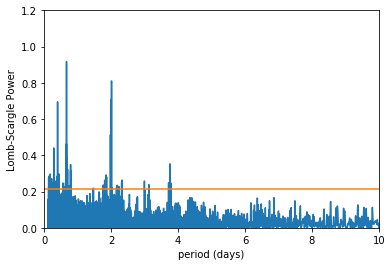

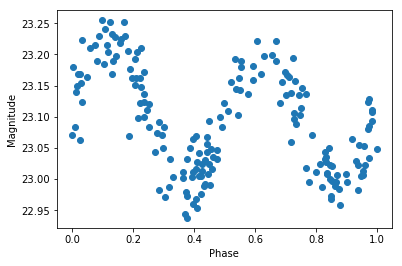

('actualperiod', 0.6666666666666666, 'measured period', 0.66666930377881783) 150


In [161]:
# actual frequency = frquency/100
lombScargle([150],([23]*7),Nquist=300) # 40 background corresponing to R band at new moon, could be made more detailed?

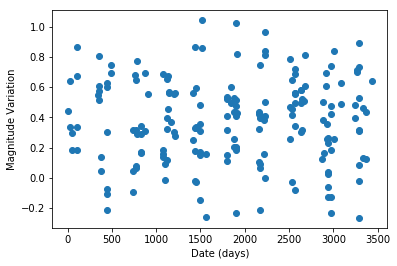

In [137]:
perfex = np.linspace(0, 3500, 3501)
#perfect = [0.1*np.sin((2*np.pi*(frange*0.01))*(x)) for x in perfex]

plt.plot(date, amplitude, 'o')
#plt.plot(perfex, perfect)
plt.ylabel('Magnitude Variation')
plt.xlabel('Date (days)')
#plt.xlim([2200, 2300])
plt.show()

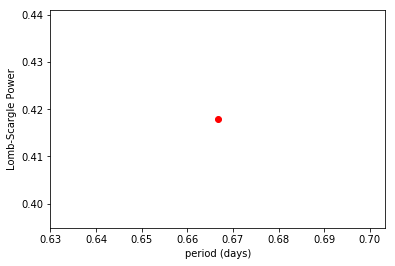

In [138]:
plt.plot(actualperiod, measuredpower)
plt.plot(measuredperiod, measuredpower, 'ro')
plt.xlabel('period (days)')
plt.ylabel('Lomb-Scargle Power')
plt.show()

In [63]:
int((LSperiod-periods[-1])/periods[-1])

4

In [65]:
periods[-5]

0.12388270645640233

In [50]:
periods

array([  1.71882300e+04,   8.59411499e+03,   5.72941000e+03, ...,
         1.23880921e-01,   1.23880028e-01,   1.23879135e-01])

In [54]:
periods[-1]

0.12387913506306306

In [67]:
(periods[0]-periods[-1])/len(periods)

0.12387824224046799

In [69]:
plist = periods.tolist()

In [72]:
plist.index(LSperiod)

ValueError: 0.66666930377881783 is not in list

In [73]:
max(periods)

17188.229989999996

In [76]:
powerlist = power.tolist()

In [77]:
max(powerlist)

TypeError: no ordering relation is defined for complex numbers

In [86]:
position = min(range(len(periods)), key=lambda i: abs(periods[i]-LSperiod))

In [92]:
if position > 10000: 
    lowermean = np.mean(power[(position-10000):(position-1)])
else:
    lowermean =np.mean(power[0:(position-1)])

(0.03237151929209587-0.0015226372878771116j)

In [90]:
if (position+10000) < len(power): 
    higermean = np.mean(power[(position+1):(position+10000)])
else:
    highermean = np.mean(power[(position+1):-1])

(0.026202621460395866-0.0012324750072965961j)

In [121]:
def findSigma():
    lowermeanlist = []
    position = min(range(len(periods)), key=lambda i: abs(periods[i]-LSperiod))
    lowermean = np.mean(power[(position-10000):(position-1)])
    lowermeanlist.append(lowermean)
    position = position - 10000
    counter = 0
    print(lowermeanlist[0], lowermeanlist[counter])
    while position > 10000 and lowermeanlist[0] <= 2 * lowermeanlist[counter]: 
        lowermean = np.mean(power[(position-10000):(position-1)])
        lowermeanlist.append(lowermean)
        counter = counter + 1
        postion = position -10000
    if position < 10000:
        lowermean = np.mean(power[0:(position-1)])
        lowermeanlist.append(lowermean)
        print('doing')
    print(lowermeanlist)

In [147]:
def findSigma(lowersteps,highersteps):
    position = min(range(len(periods)), key=lambda i: abs(periods[i]-LSperiod))
    if position > lowersteps:
        lowersig = np.std(power[(position-lowersteps):(position-1)])
        lowermean = np.mean(power[(position-lowersteps):(position-1)])
    else:
        lowersig = np.std(power[0:(position-1)])
        lowermean = np.mean(power[0:(position-1)])
        
    if (position+highersteps) < len(power): 
        highersig = np.std(power[(position+1):(position+highersteps)])
        highermean = np.mean(power[(position+1):(position+highersteps)])
    else:
        highersig = np.std(power[(position+1):-1])
        highermean = np.mean(power[(position+1):-1])
    sig = (lowersig+highersig)/2
    mean = (lowermean+highermean)/2 # means need sigma clipping, maybe use median?
    confidence = mean+(5*sig)
    return confidence

In [156]:
confidenceLevel(20000)

(0.23851503116795161-0.0015818547570721053j)

In [ ]:
def findSigma(num):
    position = min(range(len(periods)), key=lambda i: abs(periods[i]-LSperiod))
    if position > 10000:
        lowermean = np.mean(power[(position-10000):(position-1)])
        lowersig = np.std(power[(position-10000):(position-1)])
    else:
        lowermean = np.mean(power[0:(position-1)])
        lowermean = np.mean(power[0:(position-1)])
    if (position+10000) < len(power): 
        higermean = np.mean(power[(position+1):(position+10000)])
        higermean = np.mean(power[(position+1):(position+10000)])
    else:
        highermean = np.mean(power[(position+1):-1])